In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import nn

import matplotlib.pyplot as plt

from nn_functions import init_network_params, pack_params, layer_sizes, unpack_params
from nn_functions import  update_sgd, compute_hessian, update_adam
from nn_functions import get_batches, loss, batched_predict, batched_predict_with_activations

In [3]:
# Load data
field = jnp.load('field.npy')
field = field - field.mean()
field = field / field.std()
field = jnp.array(field, dtype=jnp.float32)
nx, ny = field.shape
xx = jnp.linspace(-1, 1, nx)
yy = jnp.linspace(-1, 1, ny)
xx, yy = jnp.meshgrid(xx, yy, indexing='ij')
xx = jnp.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
ff = field.reshape(-1, 1)

In [112]:
from jax import random, grad
from jax.tree_util import tree_map
import jax.numpy as jnp

def train_model(
    num_epochs=400,
    rng_key=random.key(0),
    batch_size=64,
    step_size=0.005,
    update=update_adam,
    patience=10,
    tol_loss=1e-5
):
    # Inicializar red
    params = init_network_params(layer_sizes, rng_key)
    params = pack_params(params)

    # Inicializar Adam (o SGD si se adapta la interfaz)
    aux_m = tree_map(jnp.zeros_like, params)
    aux_v = tree_map(jnp.zeros_like, params)
    aux_t = 0
    aux = (aux_m, aux_v, aux_t)

    # Logging
    log_train = []
    log_grads = []
    log_activations = []
    log_hessian = []

    # Early stopping
    best_loss = float('inf')
    wait = 0

    for epoch in range(num_epochs):
        idxs = random.permutation(rng_key, xx.shape[0])
        for xi, yi in get_batches(xx[idxs], ff[idxs], bs=batch_size):
            params, aux, grads = update(params, xi, yi, step_size, aux)

        train_loss = loss(params, xx, ff)
        log_train.append(train_loss.item())

        # Early stopping
        if train_loss < best_loss - tol_loss:
            best_loss = train_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Corte temprano por paciencia en epoch {epoch}")
                break

        # Logging cada 20 epochs
        if epoch % 10 == 0 or epoch==num_epochs-1:
            grads = grad(loss)(params, xx, ff)
            log_grads.append(grads)
            outputs, activations = batched_predict_with_activations(params, xx)
            log_activations.append(activations)
            xi, yi = next(get_batches(xx, ff, bs=batch_size))  # para el Hessiano
            log_hessian.append(compute_hessian(params, xi, yi))
            print(f"Epoch {epoch}, Loss: {train_loss}")

    return {
        "params": params,
        "log_train": log_train,
        "log_grads": log_grads,
        "log_activations": log_activations,
        "log_hessian": log_hessian,
        "final_epoch": epoch,
        "final_loss": train_loss.item()
    }

# Con scheduler con performance

In [153]:
def train_model(
    num_epochs=400,
    rng_key=random.key(0),
    batch_size=64,
    step_size=0.005,
    update=update_adam,
    patience=10,
    tol_loss=1e-5,
    use_scheduler=True,
    lr_decay=0.5,
    lr_patience=5,
    min_step_size=1e-6
):
    # Inicializar red
    params = init_network_params(layer_sizes, rng_key)
    params = pack_params(params)

    # Inicializar Adam (o SGD)
    aux_m = tree_map(jnp.zeros_like, params)
    aux_v = tree_map(jnp.zeros_like, params)
    aux_t = 0
    aux = (aux_m, aux_v, aux_t)

    # Logging
    log_train = []
    log_grads = []
    log_activations = []
    log_hessian = []

    # Early stopping y scheduler
    best_loss = float('inf')
    wait = 0
    lr_wait = 0  # contador separado para el scheduler

    for epoch in range(num_epochs):
        idxs = random.permutation(rng_key, xx.shape[0])
        for xi, yi in get_batches(xx[idxs], ff[idxs], bs=batch_size):
            params, aux, grads = update(params, xi, yi, step_size, aux)

        train_loss = loss(params, xx, ff)
        log_train.append(train_loss.item())

        # Early stopping
        if train_loss < best_loss - tol_loss:
            best_loss = train_loss
            wait = 0
            lr_wait = 0
        else:
            wait += 1
            lr_wait += 1
            if wait >= patience:
                print(f"Corte temprano por paciencia en epoch {epoch}")
                break
            # Scheduler
            if use_scheduler and lr_wait >= lr_patience:
                old_step_size = step_size
                step_size = max(min_step_size, step_size * lr_decay)
                lr_wait = 0
                print(f"Reduciendo step_size: {old_step_size:.5f} → {step_size:.5f} (epoch {epoch})")

        # Logging
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            grads = grad(loss)(params, xx, ff)
            log_grads.append(grads)
            outputs, activations = batched_predict_with_activations(params, xx)
            log_activations.append(activations)
            xi, yi = next(get_batches(xx, ff, bs=batch_size))
            log_hessian.append(compute_hessian(params, xi, yi))
            print(f"Epoch {epoch}, Loss: {train_loss:.5f}")

    return {
        "params": params,
        "log_train": log_train,
        "log_grads": log_grads,
        "log_activations": log_activations,
        "log_hessian": log_hessian,
        "final_epoch": epoch,
        "final_loss": train_loss.item(),
        "final_step_size": step_size
    }


In [150]:
1e-6

1e-06

In [ ]:
results = train_model(
    num_epochs=400,
    rng_key=random.key(65),
    batch_size=64,
    step_size=0.01,
    update=update_adam,
    patience=10,
    tol_loss=1e-5,
    use_scheduler=True,
    lr_decay=0.5,
    lr_patience=5,
    min_step_size=1e-6
)


Epoch 0, Loss: 0.06535
Epoch 10, Loss: 0.03577
Epoch 20, Loss: 0.02689
Epoch 30, Loss: 0.02485


In [129]:
"""
A mayor batch_size, suele hacer falta un learning_rate más alto.
A menor batch_size, conviene un learning_rate más bajo.
"""
results = train_model( num_epochs=400,
    rng_key=random.key(65),
    batch_size=64,
    step_size=0.005,
    update=update_adam,
    patience=10,
    tol_loss=1e-5)

Epoch 0, Loss: 0.06840823590755463
Epoch 10, Loss: 0.032237760722637177
Epoch 20, Loss: 0.030960405245423317
Epoch 30, Loss: 0.02672305516898632
Epoch 40, Loss: 0.023798758164048195
Epoch 50, Loss: 0.021582603454589844
Epoch 60, Loss: 0.0194491446018219
Epoch 70, Loss: 0.01773824356496334
Epoch 80, Loss: 0.017257504165172577
Epoch 90, Loss: 0.016838788986206055
Epoch 100, Loss: 0.01633470691740513
Epoch 110, Loss: 0.015790332108736038
Epoch 120, Loss: 0.01556898932904005
Epoch 130, Loss: 0.015439819544553757
Epoch 140, Loss: 0.014886328019201756
Epoch 150, Loss: 0.014395516365766525
Epoch 160, Loss: 0.013987423852086067
Epoch 170, Loss: 0.013776241801679134
Epoch 180, Loss: 0.013240167871117592
Epoch 190, Loss: 0.012788726948201656
Epoch 200, Loss: 0.012329989112913609
Epoch 210, Loss: 0.012106685899198055
Epoch 220, Loss: 0.011921421624720097
Epoch 230, Loss: 0.011632870882749557
Epoch 240, Loss: 0.011379730887711048
Epoch 250, Loss: 0.011048371903598309
Epoch 260, Loss: 0.01091941911

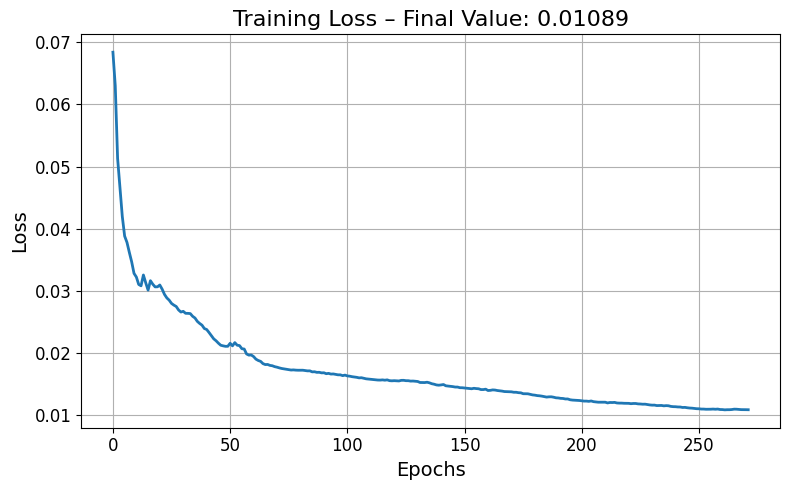

In [137]:
plt.figure(figsize=(8, 5))  # Tamaño del gráfico

plt.plot(results["log_train"], label='Training Loss', linewidth=2)

plt.title(f'Training Loss – Final Value: {results["log_train"][-1]:.5f}', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.grid(True)
#plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


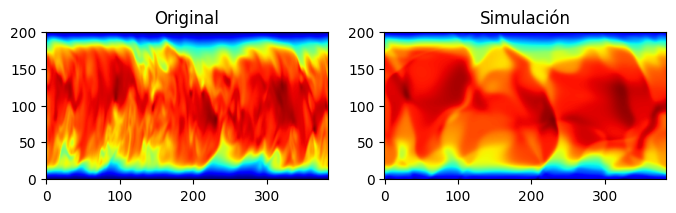

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].imshow(ff.reshape((nx, ny)).T, origin='lower', cmap='jet')
axes[0].set_title(f"Original")
result= batched_predict(results["params"], xx)
axes[1].imshow(result.reshape((nx, ny)).T, origin='lower', cmap='jet')
axes[1].set_title(f"Simulación")

plt.show()

In [120]:
import seaborn as sns

def graficar_gradientes(results): 
    # Inicializamos estructuras para acumular gradientes
    num_layers = len(layer_sizes) - 1
    grad_weights_by_layer = [[] for _ in range(num_layers)]
    grad_biases_by_layer = [[] for _ in range(num_layers)]
    log_grads = results
    # Recolectamos gradientes por capa y tipo
    for grads in log_grads:
        layer_grads = unpack_params(grads)  # Lista de (w, b) por capa
        for i, (w, b) in enumerate(layer_grads):
            grad_weights_by_layer[i].append(w.flatten())
            grad_biases_by_layer[i].append(b.flatten())
    return grad_weights_by_layer, grad_biases_by_layer


def plot_distributions(data_by_layer, param_type):
    for i, layer_data in enumerate(data_by_layer[:-1]):  # layer_data: lista de arrays (uno por época)
        plt.figure(figsize=(8, 5))
        for j, values in enumerate(layer_data):
            if  j == 0 or j == 1 or j == int(5) or j == len(layer_data)-1:
                sns.kdeplot(values, label=f"{10*j}", linewidth=2)
        plt.title(f"Distribución de ∇Loss con respecto a {param_type} - Capa {i+1}")
        #plt.xlabel("Valor")
        plt.ylabel("Densidad estimada")
        plt.grid(True)
        plt.legend()
        plt.legend(title="# Epoch:")
        plt.tight_layout()
        plt.show()


In [107]:
len(grad_weights_by_layer[0][0])

128

In [108]:
2*64

128

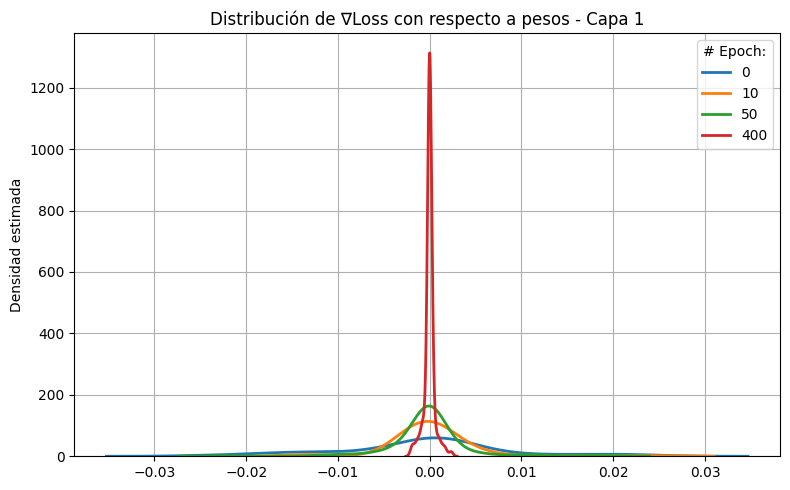

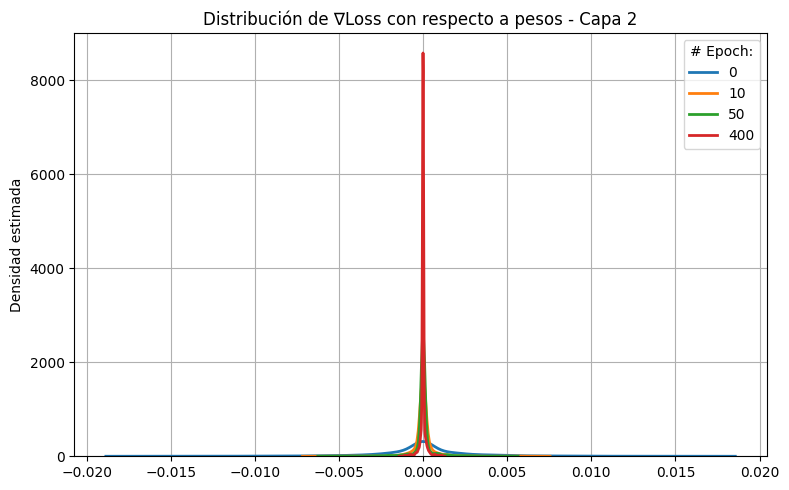

In [127]:
grad_weights_by_layer, grad_biases_by_layer = graficar_gradientes(results["log_grads"])
plot_distributions(grad_weights_by_layer, "pesos")

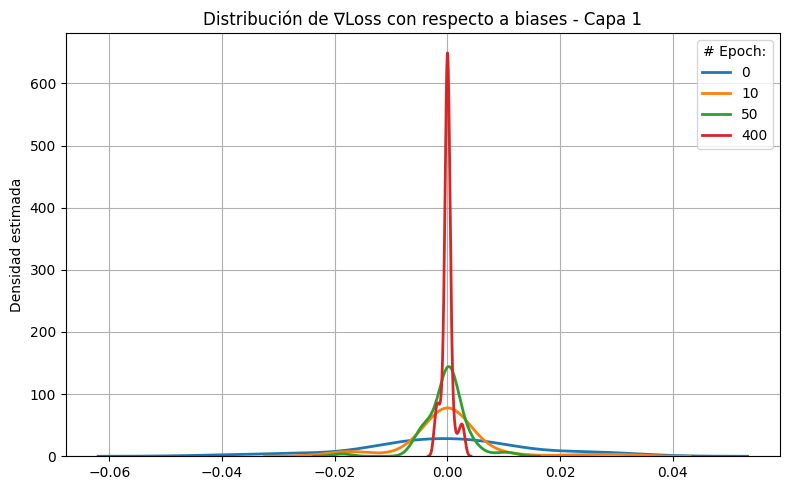

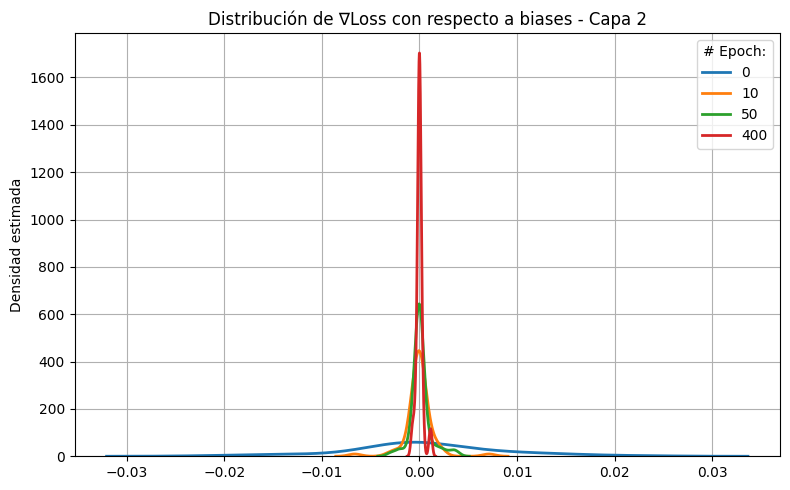

In [128]:
plot_distributions(grad_biases_by_layer, "biases")

In [147]:
len(grad_biases_by_layer[0][0])

64

In [149]:
len(grad_biases_by_layer[1][0])

64